# BirdClef-2023: Create Spectrograms from OOG files

References:

https://www.kaggle.com/code/markwijkhuizen/birdclef-2024-eda-preprocessed-dataset

Librosa MelSpectrograms
https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio

from tqdm.notebook import tqdm

import librosa
import cv2
import pickle
import lzma

# Configs

In [2]:
class Config():
    # Horizontal melspectrogram resolution
    MELSPEC_H = 128
    # Competition Root Folder
    ROOT_FOLDER = '/kaggle/input/birdclef-2023'
    # Maximum decibel to clip audio to
    TOP_DB = 100
    # Minimum rating
    MIN_RATING = 3.0
    # Sample rate as provided in competition description
    SR = 32000
    N_FFT = 2000
    HOP_LENGTH = 500
    
CONFIG = Config()

# Train metadata

In [3]:
train_metadata_df = pd.read_csv('/kaggle/input/birdclef-2023/train_metadata.csv',
        dtype={'secondary_labels': 'string',
            'primary_label': 'category',},)
train_metadata_df.columns
train_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16941 entries, 0 to 16940
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   primary_label     16941 non-null  category
 1   secondary_labels  16941 non-null  string  
 2   type              16941 non-null  object  
 3   latitude          16714 non-null  float64 
 4   longitude         16714 non-null  float64 
 5   scientific_name   16941 non-null  object  
 6   common_name       16941 non-null  object  
 7   author            16941 non-null  object  
 8   license           16941 non-null  object  
 9   rating            16941 non-null  float64 
 10  url               16941 non-null  object  
 11  filename          16941 non-null  object  
dtypes: category(1), float64(3), object(7), string(1)
memory usage: 1.5+ MB


In [4]:
# Convert secondary_labels to iterable tuple
def parse_secondary_labels(s):
    s = s.strip("[']")
    s = s.split("', '")
    return tuple([e for e in s if len(e) > 0])

train_metadata_df['secondary_labels'] = train_metadata_df['secondary_labels'].apply(parse_secondary_labels)

# Number of samples
CONFIG.N_SAMPLES = len(train_metadata_df)
print(f'# Samples: {CONFIG.N_SAMPLES:,}')

display(train_metadata_df.head())
#display(train_metadata_df.info())

# Samples: 16,941


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,(),['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,(),['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,(),['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,(),['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,(),"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [5]:
sample_submission = pd.read_csv('/kaggle/input/birdclef-2023/sample_submission.csv')

# Set labels
CONFIG.LABELS = sample_submission.columns[1:]
CONFIG.N_LABELS = len(CONFIG.LABELS)
print(f'# labels: {CONFIG.N_LABELS}')

display(sample_submission.head())

# labels: 264


,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_metadata_df.primary_label.nunique()

264

# Quick load and display audio and spectrograms

https://www.kaggle.com/code/awsaf49/birdclef24-kerascv-starter-train

In [7]:
import IPython.display as ipd
import librosa.display as lid
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')

/tmp/ipykernel_18/512615181.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [8]:
import os

class CFG:
    seed = 42
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000

    # Class Labels for BirdCLEF 23
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2023/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

In [9]:
df = pd.read_csv('/kaggle/input/birdclef-2023/train_metadata.csv')
BASE_PATH = '/kaggle/input/birdclef-2023'
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

In [10]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

# Audio:


# Visualization:


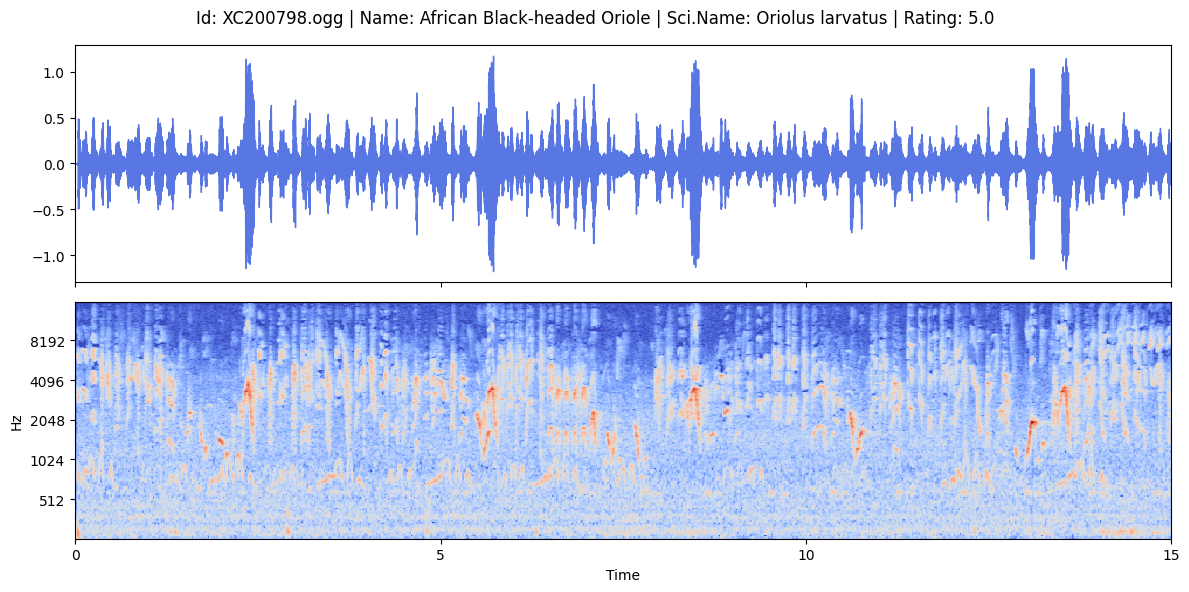

In [11]:
row = df.iloc[35]

# Display audio
display_audio(row)

# Audio:


# Visualization:


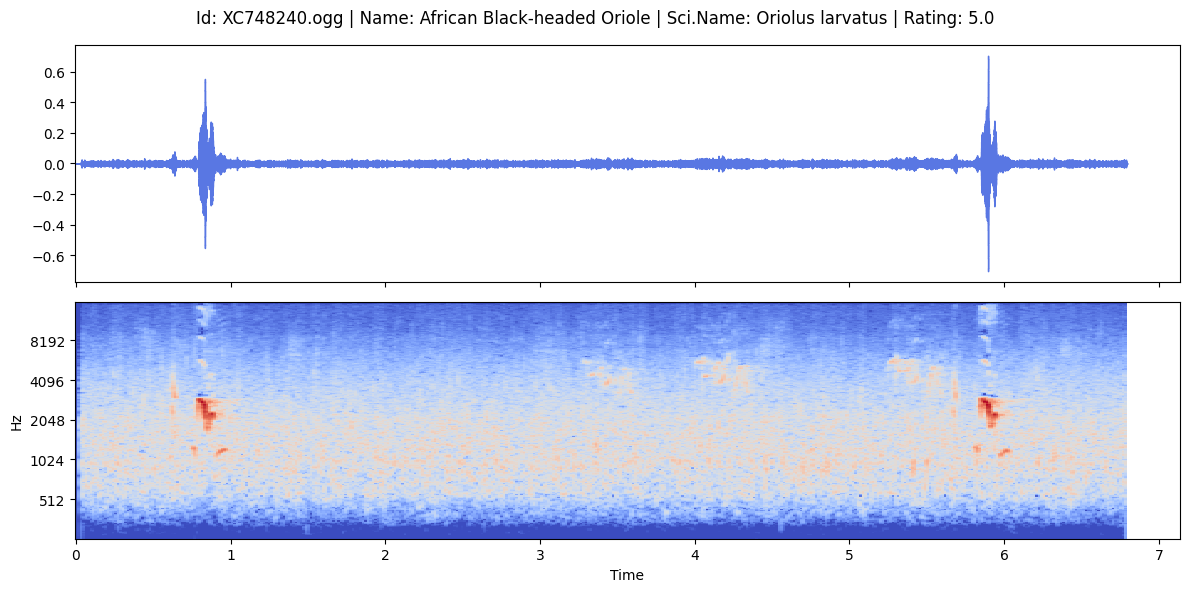

In [12]:
row = df.iloc[135]

# Display audio
display_audio(row)

# Convert OOG files to MelSpectrograms using librosa

In [13]:
# Convert OOG audio files to melspectrogram encoded as PNG bytes
def ogg2melspectrogram(file_path):
    # Load the audio file
    y, _ = librosa.load(file_path, sr=CONFIG.SR)
    # Normalize audio
    y = librosa.util.normalize(y)
    # Convert to mel spectrogram
    spec = librosa.feature.melspectrogram(
        y=y,
        sr=CONFIG.SR, # sample rate
        n_fft=CONFIG.N_FFT, # number of samples in window 
        hop_length=CONFIG.HOP_LENGTH, # step size of window
        n_mels=CONFIG.MELSPEC_H, # horizontal resolution from fmin→fmax in log scale
        fmin=40, # minimum frequency
        fmax=15000, # maximum frequency
        power=2.0, # intensity^power for log scale
    )
    # Convert to Db
    spec = librosa.power_to_db(spec, ref=CONFIG.TOP_DB)
    # Normalize 0-min
    spec = spec - spec.min()
    # Normalize 0-255
    spec = (spec / spec.max() * 255).astype(np.uint8)
    # Convert to PNG bytes
    _, spec_png_uint8 = cv2.imencode('.png', spec)
    spec_png_bytes = bytes(spec_png_uint8)
    
    return spec_png_bytes

In [14]:
# Maps a class to corresponding integer label
CLASS2LABEL = dict(zip(CONFIG.LABELS, np.arange(CONFIG.N_LABELS)))
# Label to class mapping
LABEL2CLASS = dict([(v,k) for k, v in CLASS2LABEL.items()])

In [15]:
len(list(CLASS2LABEL.keys())), list(CLASS2LABEL.keys())[:10], list(CLASS2LABEL.values())[:10]

(264,
 ['abethr1',
  'abhori1',
  'abythr1',
  'afbfly1',
  'afdfly1',
  'afecuc1',
  'affeag1',
  'afgfly1',
  'afghor1',
  'afmdov1'],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
# Create dataset
X = {}
y = {}
for idx, row in tqdm(train_metadata_df.iterrows(), total=CONFIG.N_SAMPLES):
    # Guard for absence of secundary label and minimum rating
    if row['rating'] >= CONFIG.MIN_RATING and len(row['secondary_labels']) == 0:
        # Save PNGs in X
        X[idx] = ogg2melspectrogram(f'{CONFIG.ROOT_FOLDER}/train_audio/{row.filename}')
        # Save labels in y
        y[idx] = CLASS2LABEL.get(row['primary_label'])
        
print(f'# Training Samples: {len(X):,}')

  0%|          | 0/16941 [00:00<?, ?it/s]

# Training Samples: 12,878


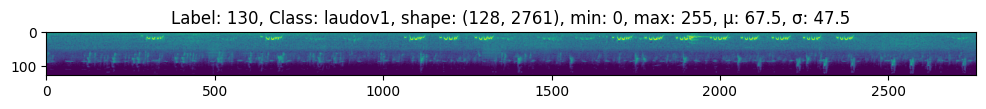

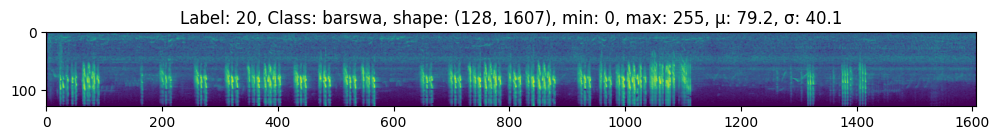

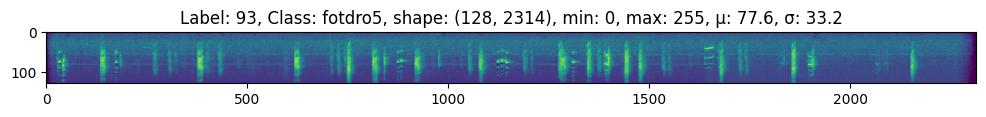

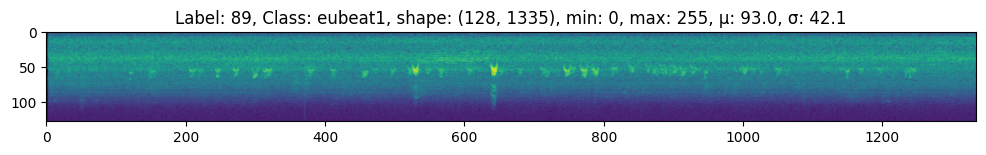

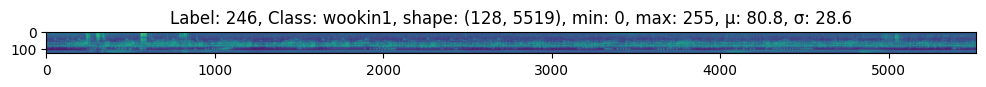

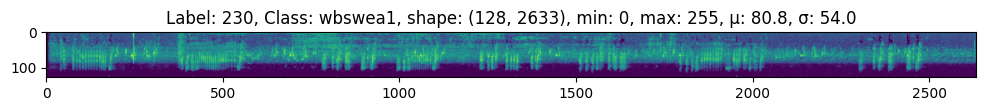

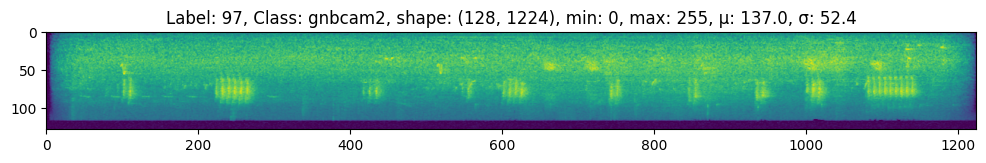

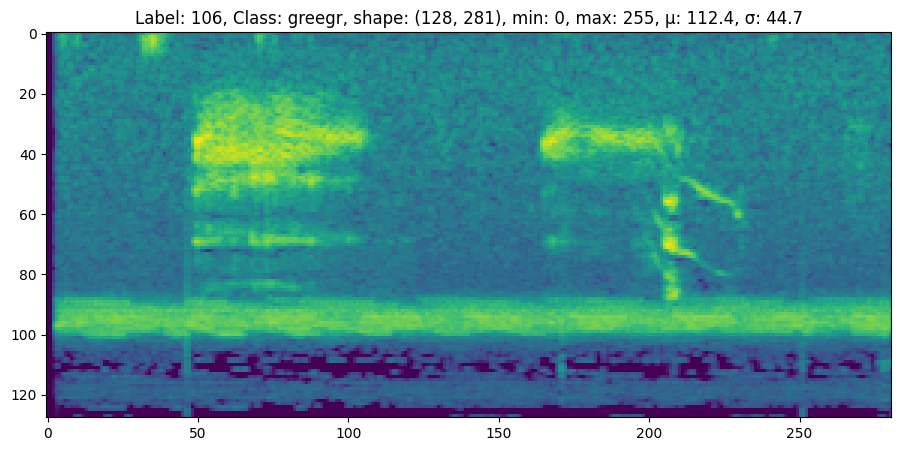

In [17]:
# Example Plots
def example_plots(X, y, N):
    np.random.seed(42)
    random_keys = np.random.choice(list(X.keys()), N)
    
    for k in random_keys:
        spec = imageio.imread(X[k])
        plt.figure(figsize=(12,5))
        plt.title(
                f'Label: {y[k]}, Class: {LABEL2CLASS[y[k]]}, shape: {spec.shape}, ' +
                f'min: {spec.min():.0f}, max: {spec.max():.0f}, ' +
                f'µ: {spec.mean():.1f}, σ: {spec.std():.1f}'
            )
        plt.imshow(spec)
        plt.show()
        
example_plots(X, y, 8)

# Write the images as pickle files

In [18]:
# Write X
with open('X.pkl', 'wb') as f:
    pickle.dump(X, f)
    
# Write y
with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)